In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv('MPS Borough Level Crime (most recent 24 months).csv')
#https://data.london.gov.uk/dataset/recorded_crime_summary

In [7]:
data.drop('MinorText',axis=1, inplace = True)


LookUp_BoroughName
Barking and Dagenham                        1562
Barnet                                      2562
Bexley                                      1412
Brent                                       2732
Bromley                                     1989
Camden                                      3140
Croydon                                     2621
Ealing                                      2600
Enfield                                     2502
Greenwich                                   2241
Hackney                                     2879
Hammersmith and Fulham                      1908
Haringey                                    2710
Harrow                                      1403
Havering                                    1669
Hillingdon                                  2383
Hounslow                                    2263
Islington                                   2368
Kensington and Chelsea                      1898
Kingston upon Thames                        1124
L

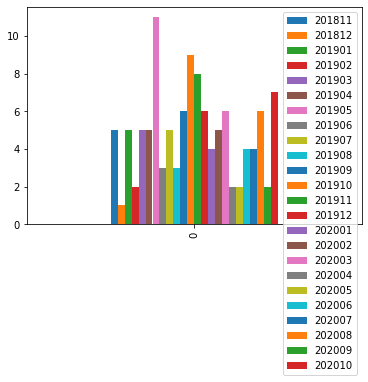

In [41]:
nov_18 = data.groupby('LookUp_BoroughName')['201811'].sum()
dec_18 = data.groupby('LookUp_BoroughName')['201812'].sum()

data.iloc[0:1].drop(['MajorText','LookUp_BoroughName'],axis=1).plot(kind='bar')
nov_18


In [119]:
crime_15 = pd.read_csv('MPS_Borough_Level_Crime_Historic.csv')

housing = pd.read_csv('London.Housing.2015.csv')
#https://data.london.gov.uk/dataset/london-housing

In [120]:
crime_15.drop(crime_15.loc[:,'200801':'201312'],axis=1,inplace=True)
crime_15.drop(crime_15.loc[:,'201601':'201812'],axis=1,inplace=True)

#df.iloc[:, 1:3]


In [121]:
crime_15.groupby('Borough')['201401'].sum()

Borough
Barking and Dagenham      1311
Barnet                    1857
Bexley                     966
Brent                     2122
Bromley                   1681
Camden                    2302
Croydon                   2484
Ealing                    1995
Enfield                   1878
Greenwich                 1627
Hackney                   2004
Hammersmith and Fulham    1595
Haringey                  1870
Harrow                    1017
Havering                  1278
Hillingdon                1634
Hounslow                  1529
Islington                 2081
Kensington and Chelsea    1402
Kingston upon Thames       692
Lambeth                   2842
Lewisham                  1806
Merton                     940
Newham                    2398
Redbridge                 1823
Richmond upon Thames       924
Southwark                 2351
Sutton                     853
Tower Hamlets             2031
Waltham Forest            1765
Wandsworth                1781
Westminster               4314


In [122]:
crime_15.head()

,Borough,Major Category,Minor Category,201401,201402,201403,201404,201405,201406,201407,...,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,112,114,143,83,90,89,105,...,129,65,61,68,89,89,77,105,111,119
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,53,55,47,47,48,42,50,...,40,42,41,26,42,56,50,34,36,32
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,37,31,35,31,30,36,28,...,32,35,46,38,37,32,28,28,36,38
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,57,73,72,47,56,57,72,...,68,56,87,57,79,65,68,65,80,105
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,16,10,12,13,13,13,12,...,14,15,15,15,8,12,10,9,16,10


In [123]:
crime_15.insert(3,'2014_total',crime_15.loc[:,'201402':'201412'].sum(axis=1))
#crime_15.loc[:,'201402':'201412'].sum(axis=1)

In [124]:
crime_15.head()

,Borough,Major Category,Minor Category,2014_total,201401,201402,201403,201404,201405,201406,...,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,1256,112,114,143,83,90,89,...,129,65,61,68,89,89,77,105,111,119
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,488,53,55,47,47,48,42,...,40,42,41,26,42,56,50,34,36,32
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,361,37,31,35,31,30,36,...,32,35,46,38,37,32,28,28,36,38
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,696,57,73,72,47,56,57,...,68,56,87,57,79,65,68,65,80,105
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,128,16,10,12,13,13,13,...,14,15,15,15,8,12,10,9,16,10


In [186]:
crime_15_all= crime_15.groupby('Borough')['2014_total'].sum()

In [180]:
crime_15_piv = pd.pivot_table(crime_15, values='2014_total', index=['Borough', 'Major Category'], aggfunc=np.sum)
crime_15_piv

2014_total
Borough              Major Category                         
Barking and Dagenham Burglary                           1744
                     Criminal Damage                    1544
                     Drugs                               993
                     Fraud or Forgery                     30
                     Other Notifiable Offences           308
...                                                      ...
Westminster          Other Notifiable Offences           815
                     Robbery                            1750
                     Sexual Offences                     700
                     Theft and Handling                25927
                     Violence Against the Person        7960

[288 rows x 1 columns]

In [176]:
housing.drop('Unnamed: 0',axis=1,inplace = True)

KeyError: "['Unnamed: 0'] not found in axis"

In [172]:
housing.drop([0,34,35],axis=0,inplace = True)

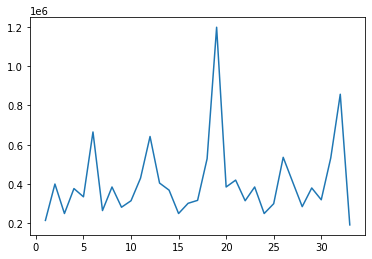

In [173]:

housing['Median House Prices, 2014']=housing['Median House Prices, 2014'].astype(str).str.replace(',','')

housing['Median House Prices, 2014'] = pd.to_numeric(housing['Median House Prices, 2014'],errors='coerce')

plt.plot(housing['Median House Prices, 2014'])


In [177]:
housing.head()

,Unnamed: 1,"Median House Prices, 2014"
1,Barking and Dagenham,215000.0
2,Barnet,400000.0
3,Bexley,250000.0
4,Brent,377000.0
5,Bromley,335000.0


In [188]:
crime_15_all

Borough
Barking and Dagenham      14917
Barnet                    21178
Bexley                    11238
Brent                     23089
Bromley                   18504
Camden                    25637
Croydon                   25863
Ealing                    23717
Enfield                   20534
Greenwich                 18997
Hackney                   23196
Hammersmith and Fulham    18157
Haringey                  21679
Harrow                    11282
Havering                  13966
Hillingdon                19999
Hounslow                  18833
Islington                 23613
Kensington and Chelsea    17058
Kingston upon Thames       8890
Lambeth                   30250
Lewisham                  20032
Merton                    10977
Newham                    26428
Redbridge                 18492
Richmond upon Thames       9793
Southwark                 27519
Sutton                     9934
Tower Hamlets             24692
Waltham Forest            19126
Wandsworth                20218


In [190]:
joint= housing.join(crime_15_all,how='inner',on='Unnamed: 1')

In [197]:
joint

,Unnamed: 1,"Median House Prices, 2014",2014_total
1,Barking and Dagenham,215000.0,14917
2,Barnet,400000.0,21178
3,Bexley,250000.0,11238
4,Brent,377000.0,23089
5,Bromley,335000.0,18504
6,Camden,665000.0,25637
7,Croydon,265000.0,25863
8,Ealing,385000.0,23717
9,Enfield,282000.0,20534
10,Greenwich,315000.0,18997


Text(0.5, 1.0, 'Each point is a borough')

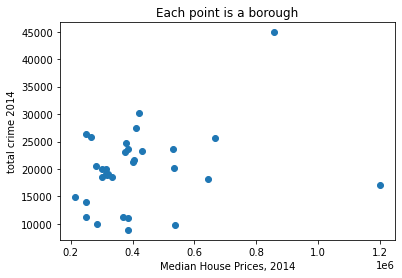

In [196]:
plt.scatter(joint['Median House Prices, 2014'],joint['2014_total'])
plt.xlabel('Median House Prices, 2014')
plt.ylabel('total crime 2014')
plt.title('Each point is a borough')